# SALES PREDICTIONS FOR ACME TEXTILE CORP

This project was developed for the IE Capstone Project with the dataset provided by KPMG of ACME Textile Corp.

1. [Import Libraries](#section-1)
2. [Data Preparation](#section-2)
3. [LSTM](#section-3)

## **1. Import Libraries**
<a id='section-1'></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [2]:
url = 'https://raw.githubusercontent.com/AmisheeChoksi/IE_Capstone_KPMG_Group9/main/IE%20KPMG_Demand%20Forecast%20dataset.csv'
df = pd.read_csv(url)
df

,year-week,ID_material,Units
0,2019-11,120010970,540
1,2019-12,120010970,750
2,2019-13,120010970,960
3,2019-14,120010970,720
4,2019-15,120010970,1620
...,...,...,...
2852,2022-35,120015996,948
2853,2022-36,120015996,600
2854,2022-37,120015996,1452
2855,2022-38,120015996,1920


## **2. Data Preparation**
<a id='section-2'></a>

In [3]:
# Create date column
df['date'] = pd.to_datetime(df['year-week'] + '-6', format='%G-%V-%u')

In [4]:
#Cleaning the "Units" column by converting the column into a float first.
df['Units'] = pd.to_numeric(df['Units'], errors='coerce').fillna(0)

#Now that the column is a float we need to round up the values that have a decimal value and convert it to an integer value.
df['Units'] = df['Units'].apply(lambda x: int(np.ceil(x)))

In [5]:
df.head()

,year-week,ID_material,Units,date
0,2019-11,120010970,540,2019-03-16
1,2019-12,120010970,750,2019-03-23
2,2019-13,120010970,960,2019-03-30
3,2019-14,120010970,720,2019-04-06
4,2019-15,120010970,1620,2019-04-13


In [6]:
df.index = df['date']

In [7]:
df = df.loc[df['ID_material'] == 120004096]

In [8]:
df['Units'] = df['Units'].astype('int')

C:\Users\amish\AppData\Local\Temp/ipykernel_23928/3292139023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Units'] = df['Units'].astype('int')


In [9]:
df.dtypes

year-week              object
ID_material             int64
Units                   int32
date           datetime64[ns]
dtype: object

In [10]:
df.head()

,year-week,ID_material,Units,date
date,,,,
2017-01-14,2017-02,120004096,120,2017-01-14
2017-01-21,2017-03,120004096,120,2017-01-21
2017-01-28,2017-04,120004096,300,2017-01-28
2017-02-04,2017-05,120004096,60,2017-02-04
2017-02-11,2017-06,120004096,120,2017-02-11


In [11]:
df = df.drop(['year-week', 'ID_material', 'date'], axis=1)

In [12]:
df

,Units
date,
2017-01-14,120
2017-01-21,120
2017-01-28,300
2017-02-04,60
2017-02-11,120
...,...
2022-09-03,180
2022-09-10,180
2022-09-17,180


<AxesSubplot:xlabel='date'>

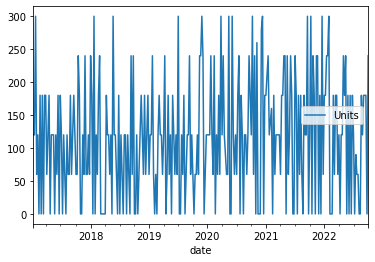

In [13]:
df.plot()

## **3. LSTM**
<a id='section-3'></a>

In [14]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [15]:
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(df['Units'], WINDOW_SIZE)
X1.shape, y1.shape

((296, 3, 1), (296,))

In [16]:
X_train1, y_train1 = X1[:200], y1[:200]
X_val1, y_val1 = X1[200:240], y1[200:240]
X_test1, y_test1 = X1[240:], y1[240:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((200, 3, 1), (200,), (40, 3, 1), (40,), (56, 3, 1), (56,))

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

#model1 = Sequential()
#model1.add(InputLayer((3, 1)))
#model1.add(LSTM(32))
#model1.add(Dense(8, 'relu'))
#model1.add(Dense(1, 'linear'))

model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(3, 1)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [18]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [19]:
model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=20, callbacks=[cp1])

Epoch 1/20
1/7 [===>..........................] - ETA: 8s - loss: 12251.5273 - root_mean_squared_error: 110.6866

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 5s 572ms/step - loss: 17774.6543 - root_mean_squared_error: 133.3216 - val_loss: 24426.6797 - val_root_mean_squared_error: 156.2904
Epoch 2/20
1/7 [===>..........................] - ETA: 0s - loss: 14793.4062 - root_mean_squared_error: 121.6282

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 4s 589ms/step - loss: 16376.3047 - root_mean_squared_error: 127.9699 - val_loss: 22137.8906 - val_root_mean_squared_error: 148.7881
Epoch 3/20
1/7 [===>..........................] - ETA: 0s - loss: 13992.1748 - root_mean_squared_error: 118.2885

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 4s 610ms/step - loss: 14582.8291 - root_mean_squared_error: 120.7594 - val_loss: 18488.9629 - val_root_mean_squared_error: 135.9741
Epoch 4/20
1/7 [===>..........................] - ETA: 0s - loss: 21125.6680 - root_mean_squared_error: 145.3467

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 4s 712ms/step - loss: 12103.7012 - root_mean_squared_error: 110.0168 - val_loss: 13780.9404 - val_root_mean_squared_error: 117.3923
Epoch 5/20
1/7 [===>..........................] - ETA: 0s - loss: 12024.7617 - root_mean_squared_error: 109.6575

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 4s 639ms/step - loss: 9685.3877 - root_mean_squared_error: 98.4144 - val_loss: 11568.2461 - val_root_mean_squared_error: 107.5558
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 9182.0137 - root_mean_squared_error: 95.8228 - val_loss: 11649.9873 - val_root_mean_squared_error: 107.9351
Epoch 7/20
7/7 [==============================] - 0s 9ms/step - loss: 8940.8281 - root_mean_squared_error: 94.5560 - val_loss: 11797.2725 - val_root_mean_squared_error: 108.6152
Epoch 8/20
7/7 [==============================] - 0s 8ms/step - loss: 8797.5703 - root_mean_squared_error: 93.7954 - val_loss: 11841.5273 - val_root_mean_squared_error: 108.8188
Epoch 9/20
7/7 [==============================] - 0s 8ms/step - loss: 8731.0371 - root_mean_squared_error: 93.4400 - val_loss: 11681.5234 - val_root_mean_squared_error: 108.0811
Epoch 10/20
7/7 [==============================] - 0s 5ms/step - loss: 8650.6406 - root_mean_squared_error: 93.0088 - v

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 4s 640ms/step - loss: 8570.5342 - root_mean_squared_error: 92.5772 - val_loss: 11553.6582 - val_root_mean_squared_error: 107.4879
Epoch 12/20
1/7 [===>..........................] - ETA: 0s - loss: 5312.5376 - root_mean_squared_error: 72.8872

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 3s 558ms/step - loss: 8460.4316 - root_mean_squared_error: 91.9806 - val_loss: 11261.5723 - val_root_mean_squared_error: 106.1206
Epoch 13/20
1/7 [===>..........................] - ETA: 0s - loss: 7534.6118 - root_mean_squared_error: 86.8021

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 4s 714ms/step - loss: 8325.3721 - root_mean_squared_error: 91.2435 - val_loss: 11125.0732 - val_root_mean_squared_error: 105.4755
Epoch 14/20
1/7 [===>..........................] - ETA: 0s - loss: 9380.9951 - root_mean_squared_error: 96.8555

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 3s 559ms/step - loss: 8037.0093 - root_mean_squared_error: 89.6494 - val_loss: 10998.4453 - val_root_mean_squared_error: 104.8735
Epoch 15/20
7/7 [==============================] - 0s 9ms/step - loss: 8169.8823 - root_mean_squared_error: 90.3874 - val_loss: 11065.6621 - val_root_mean_squared_error: 105.1935
Epoch 16/20
7/7 [==============================] - 0s 9ms/step - loss: 7621.2500 - root_mean_squared_error: 87.2998 - val_loss: 11113.9355 - val_root_mean_squared_error: 105.4227
Epoch 17/20
7/7 [==============================] - 0s 8ms/step - loss: 7489.8564 - root_mean_squared_error: 86.5440 - val_loss: 11404.0635 - val_root_mean_squared_error: 106.7898
Epoch 18/20
7/7 [==============================] - 0s 8ms/step - loss: 7328.8599 - root_mean_squared_error: 85.6088 - val_loss: 11679.6270 - val_root_mean_squared_error: 108.0723
Epoch 19/20
7/7 [==============================] - 0s 10ms/step - loss: 7270.2495 - root_mean_squared_error: 85.265

In [20]:
from tensorflow.keras.models import load_model
model1 = load_model('model/')

In [21]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

7/7 [==============================] - 0s 3ms/step


,Train Predictions,Actuals
0,126.179344,60
1,158.904327,120
2,162.459717,0
3,89.351318,180
4,96.239853,0
...,...,...
195,139.878693,0
196,116.151840,260
197,133.248779,0
198,74.630531,0


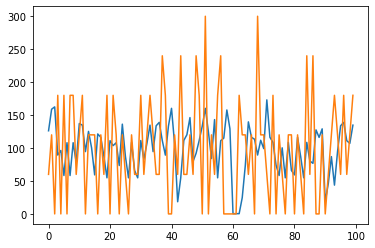

In [22]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])

In [23]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

2/2 [==============================] - 0s 4ms/step


,Val Predictions,Actuals
0,0.381040,280
1,32.862587,300
2,110.297607,0
3,192.476532,180
4,139.429565,180
5,77.948448,210
6,155.751892,240
7,165.154617,120
8,171.308899,140
9,158.586914,160


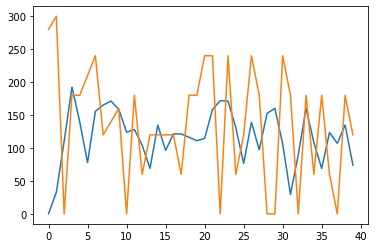

In [24]:
plt.plot(val_results['Val Predictions'][:40])
plt.plot(val_results['Actuals'][:40])

In [25]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

2/2 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,73.430870,120
1,139.701508,300
2,126.179344,0
3,160.521561,120
4,143.154984,300
5,84.703400,0
6,160.521561,240
7,147.808563,180
8,90.035126,0
9,160.246307,240


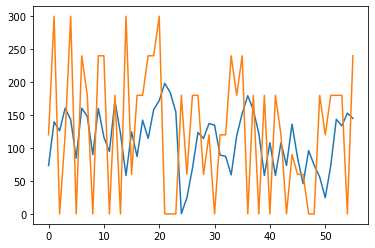

In [26]:
plt.plot(test_results['Test Predictions'][:56])
plt.plot(test_results['Actuals'][:56])

As highlighted by the test predictions above, the results of this LSTM model are unsatisfactory. Our main assumption is that the lack of data is penalizing the model. Recurrent Neural Networks require a large amount of training information in order to provide good results. LSTM models however remain a good option when dealing with sales forecasting problems.